In [3]:
from sklearn.datasets import fetch_openml
import joblib

# Uncomment to download the dataset for the first time (takes about 30 seconds)
# mnist = fetch_openml('mnist_784', version=1)
# joblib.dump(mnist, "mnist.pkl")

mnist = joblib.load("mnist.pkl")
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

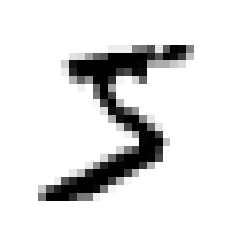

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.values[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
import numpy as np
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X.values[:60000], X.values[60000:], y.values[:60000], y.values[60000:]

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
joblib.dump(sgd_clf, "sgd_clf.pkl")
# Uncomment if you want to load saved classifier from previous runs instead of training again
# sgd_clf = joblib.load("sgd_clf.pkl")

sgd_clf.predict([some_digit])

array([ True])

In [12]:
# Custom implementation of Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

# output:
#                            Predicted    Predicted
#                         as non-fives:   as fives:        
# Actual images of non-fives:  [[53892,   687],
# Actual images of fives:       [ 1891,  3530]]
#
#                               [[TN,  FP]
#                                [FN,  TP]]
#


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
# F1 is the "harmonic mean". The regular mean gives equal weight to all values, but the harmonic mean gives more
#  weight to low values. You have to have a high values for both precision and recall to have a good F1 score, or
# more specifically, the F1 score favors classifiers that have a similar precision and recall.

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

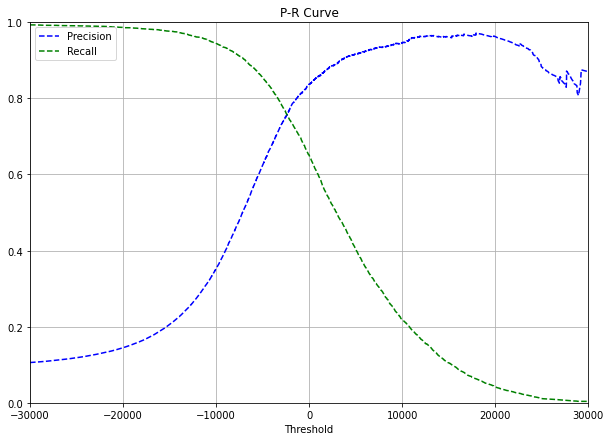

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,7))    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend()
    plt.title("P-R Curve")
    plt.xlabel("Threshold")
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.axis([-30000, 30000, 0, 1])

plt.show()

3370.0194991439557
0.9000345901072293
0.4799852425751706


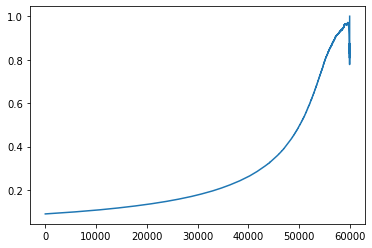

In [27]:
# Obtaining the threshhold for a given precision or recall

# What's happening here is a little obscure. It is based on the fact that precision_recall_curve() returned all the
# possible precision values in ascending order. Since we are calling argmax on an array of bools there is now "max" and
# it just returns the index of the first True it finds. Thus we use argmax to find the exact threshhold that gives us 
# 90% precision.

plt.plot(precisions)

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

# AUC (Area Under the Curve) should range from 0.5 (the random classifier) to 1.0 (perfect)

0.9604938554008616

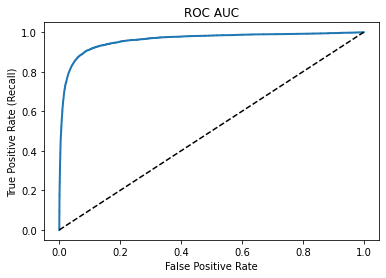

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # A straight line with a slope of one represents a random classifier operating on coin
    # flips. The ROC AUC of that classifier will always be 0.5, so that is the worst
    # possible score and we want to be as far above that as possible.
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC AUC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

plot_roc_curve(fpr, tpr)
plt.show()

## How to choose between ROC curve and Precision-Recall curve

In most cases, we prefer to evaluate based on the ROC curve. However, if you care a lot about false positives (which are highlighted by Precision), or as in our case the postive class is rare, the P-R curve can illustrate this more dramatically. For example, we have a very high ROC AUC, but this is only because 5's occur just 10% of the time. We know from our P-R curve that Precision and Recall are only about 73% when they are equal and tradeoff is fairly steep after that, so there is actually a lot of room for improvement with this classifier.

Note: F1 is the preferred metric for summarizing the P-R curve.

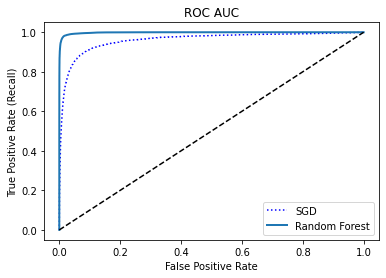

In [30]:
# Compare now with Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
joblib.dump(forest_clf, "forest_clf.pkl")
# Uncomment if you want to load saved classifier from previous runs instead of training again
# forest_clf = joblib.load("forest_clf.pkl")
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# Random Forest's predict_proba method returns an n x c matrix, where it has a column showing the probability for each class
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Curve 1 on the plot
plt.plot(fpr, tpr, "b:", label="SGD")
# Curve 2 on the plot
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [31]:
from sklearn.metrics import f1_score

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

sgd_auc = roc_auc_score(y_train_5, y_scores)
forest_auc = roc_auc_score(y_train_5, y_scores_forest)
sgd_f1 = f1_score(y_train_5, y_train_pred)
forest_f1 = f1_score(y_train_5, y_train_pred_forest)

print(f"SGD AUC: {sgd_auc}")
print(f"Forest AUC: {forest_auc}")
print(f"SGD F1: {sgd_f1}")
print(f"Forest F1: {forest_f1}")

SGD AUC: 0.9604938554008616
Forest AUC: 0.9983436731328145
SGD F1: 0.7325171197343846
Forest F1: 0.9242275142688446


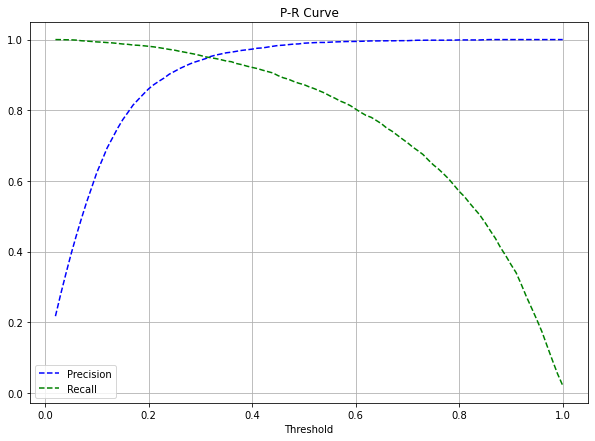

In [32]:
precisions_f, recalls_f, thresholds_f = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_recall_vs_threshold(precisions_f, recalls_f, thresholds_f)
plt.show()

In [33]:
print(len(y_scores_forest))
print(len(thresholds_f))

# There's an interesting quirk happening here. We're supposed to get a threshold for each
# instance in our training set, but in this case we get very few. There is a small note
# in the docs that mentions that we only get a number of thresholds equal to the unique
# scores given to precision_recall_curve(): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# This prevented me from setting a high-recall threshold for random_forest in the way we did
# for SGD. I'm sure there is way, I'll have to look closer later though.

60000
99


# Multiclass Classification

Algorithms that natively handle multiple classes:
- SGD
- Random Forest
- Naive Bayes

Algorithms that only handle binary classification:
- Logistic Regression
- SVM

Strategies for turning a binary classifier into multiclass:
1. One Versus One (OvO)
- Binary classify between every pair of classes (0s and 1s, 0s and 2s, 1s and 2s, etc)
- This means training 45 classifiers for MNIST, and it means running all 45 at prediction time
- The winner of most duels is the class (for an actual 5, the 5 classifier should win 9 duels while all the rest should win 4 or 5 based on randomness)
2. One Versus All (OvA)
- Train one binary classifier for each class (0-detector, 1-detector, etc.) and judge by the classifier with the highest score. (For an actual 5, the 1-detector will likely give a low score, but the 5 and 6 might give high scores. Hopefully the 5-detector will give the highest score.)

Algorithms like SVM that scale poorly to large training sets are actually more efficient to run with OvO (you only train on 2/10 of the training data for each classifier). But for all others OvR is more efficient

Scikit learn automatically adjusts binary classifiers to work with multiclass data. See next cell for doing multiclass with SVM:

In [34]:
from sklearn.svm import SVC

# Training the SVM takes 3 minutes, so be default loading this from a saved model
# svm_clf = SVC()
# svm_clf.fit(X_train, y_train)
# joblib.dump(svm_clf, "svm_clf.pkl")

svm_clf = joblib.load("svm_clf.pkl")
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

# Looking at the scores, you can see that class 5 did have the highest score with 9.31, but it
# also socred 3 and 2 fairly highly as well.

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [36]:
# Forcing sklearn to use OvA instead of OvO
from sklearn.multiclass import OneVsRestClassifier

# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)
joblib.dump(ovr_clf, "ovr_clf.pkl")
ovr_clf = joblib.load("ovr_clf.pkl")

# Takes 20 minutes to run this cell

NameError: name 'ovr_clf' is not defined

In [ ]:
print(ovr_clf.predict([some_digit]))
len(ovr_clf.estimators_)

In [37]:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))
sgd_clf.decision_function([some_digit])

# Takes 2 minutes to run this cell

[3]


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [38]:
# Improvement of SGD by applying standard deviation scaling to the pixel values
# (See chapter 2)

original_cv_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
scaling_cv_scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

print(f"Without std dev scaling: {original_cv_scores}")
print(f"With std dev scaling: {scaling_cv_scores}")

# Takes 13 minutes to run this cell


Without std dev scaling: [0.87365 0.85835 0.8689 ]
With std dev scaling: [0.8983 0.891  0.9018]


In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx